In [1]:
from IPython.display import Image

browser ---- http ---- system-----------------
                                
                                |
system(App) ---- http, txt, json, csv ... ------


    --> 송수신 : 'REST ful' API

- OAuth : 인증

new notebook 

 - sc.version
 - sc.master
 - sc.sparkUser
 
------

#### import

    import org.apache.spark.streaming.{Seconds, StreamingContext}
    import org.apache.spark.streaming.twitter.TwitterUtils

-----
#### SparkConf 추출

    val sparkConf = sc.getConf

-----
#### Twitter Key 준비

    val Array(consumerKey, consumerSecret, accessToken, accessTokenSecret) = Array("V6EHErISuwUpQ6XjBiKb9w0ma", "BKSHpUcKfm20tjbLhHMsUoCSOtZmyDAvvh1Ys60ZpWgPnzbN4I", "168871039-Mey1xGwI6kLCMlA9JG5DyjjbaQn65ALK8UE1v4Wr", "dXCUeeE6fambroiIjs6ZvnBYsLXXvUTX53UYwOzhqlIJV")
 
 ----
#### Twitter Key 환경변수 등록

    System.setProperty("twitter4j.oauth.consumerKey", consumerKey)
    System.setProperty("twitter4j.oauth.consumerSecret", consumerSecret)
    System.setProperty("twitter4j.oauth.accessToken", accessToken)
    System.setProperty("twitter4j.oauth.accessTokenSecret", accessTokenSecret)
    
 -----


#### Twitter 인증정보 생성 유틸리티

object Utils {

 def getAuth = {
     
    import org.apache.commons.cli.{Options, ParseException, PosixParser}
    import org.apache.spark.mllib.linalg.Vector
    import org.apache.spark.mllib.feature.HashingTF
    import twitter4j.auth.OAuthAuthorization
    import twitter4j.conf.ConfigurationBuilder
    
    val Array(consumerKey, consumerSecret, accessToken, accessTokenSecret) = Array("edgWhFgM9GML1TfA7hvzALTE9", "Jssdq2Kt1RDR3P0hG0GvpFvtjMg0JkG7LMR8qsq3ZhW8Wv9OVS", "168871039-RZ0pUTk1Ixzju4Dv0hmr6w1b0Mt7shlvHLnClqaO", "cICFbap5aoOQW2WB7Jpd0HwKL1viFv5BCg9pM8UMbWTkB")
        
    val builder: ConfigurationBuilder = new ConfigurationBuilder()
    builder.setOAuthConsumerKey(consumerKey);
    builder.setOAuthConsumerSecret(consumerSecret);
    builder.setOAuthAccessToken(accessToken);
    builder.setOAuthAccessTokenSecret(accessTokenSecret);
    Some(new OAuthAuthorization(builder.build()))
  }
  
-----

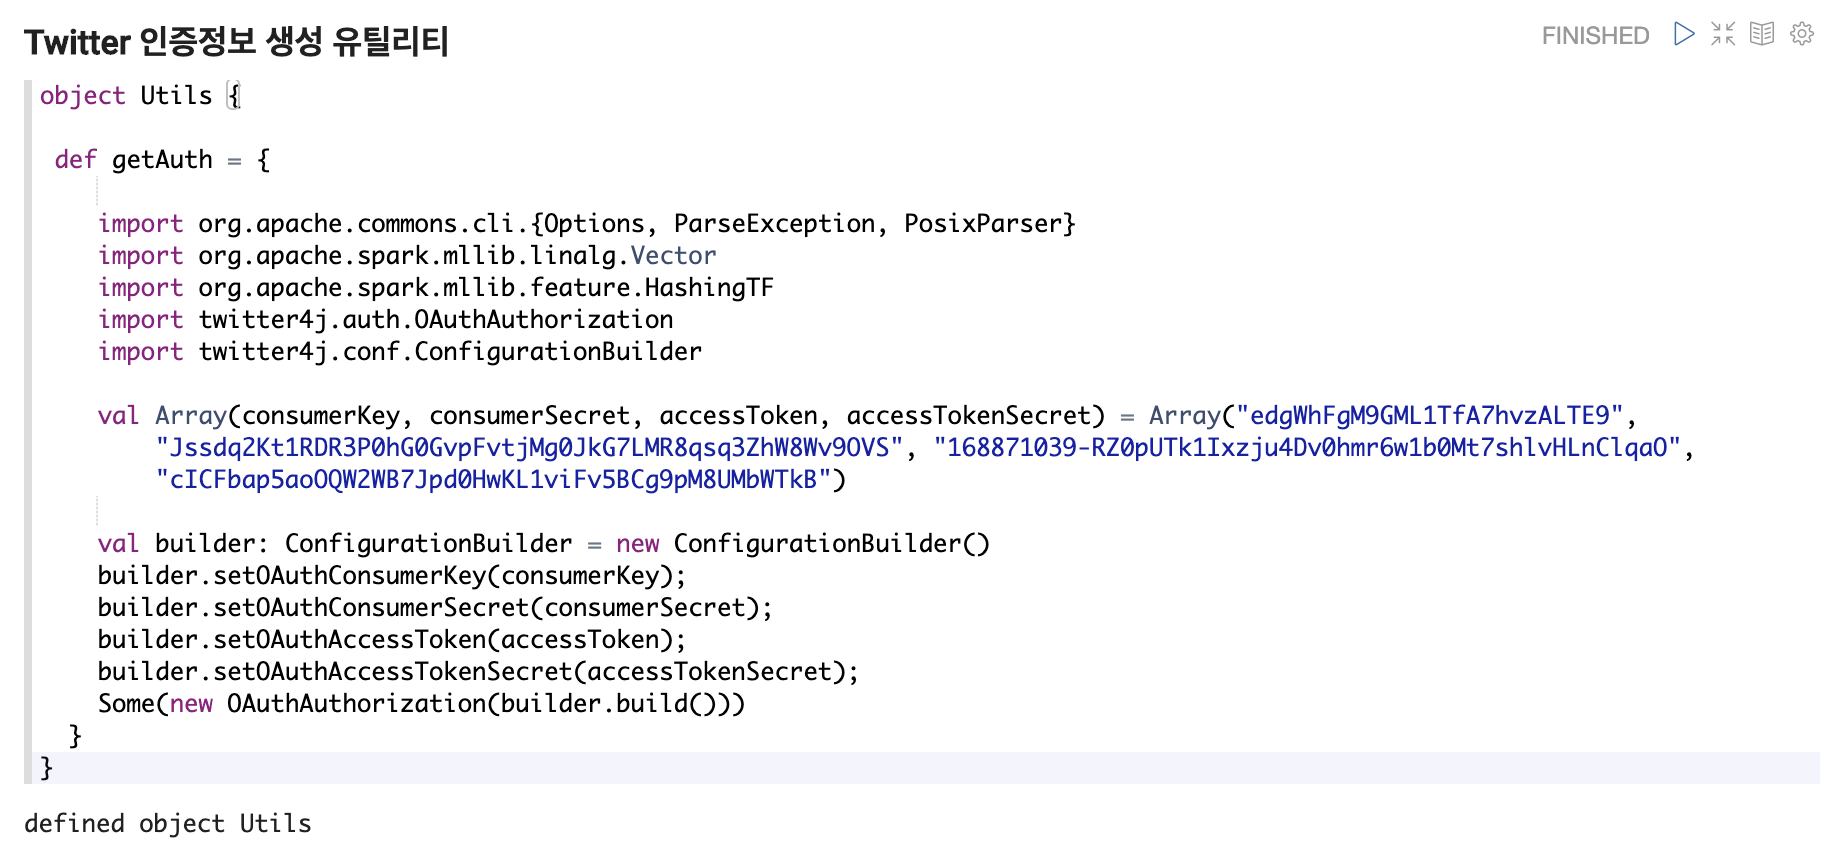

In [13]:
Image('./capture/twitter_07.png')

#### StreamingContext 생성

    val ssc = new StreamingContext(sparkConf, Seconds(2))
    
    --> val ssc = new StreamingContext(sc, Seconds(2))

 - 2초동안 streaming 되는 데이터를 받아오자.
 - Batch (일괄처리) vs Streaming (실시간 처리)
 - crontab 과 비슷 
----- 
HDFS / MySQL

----> spark (batch)
    - RDD
    - DF
----> 2s 마다 RDD 생성 (들어온 순서대로 처리)

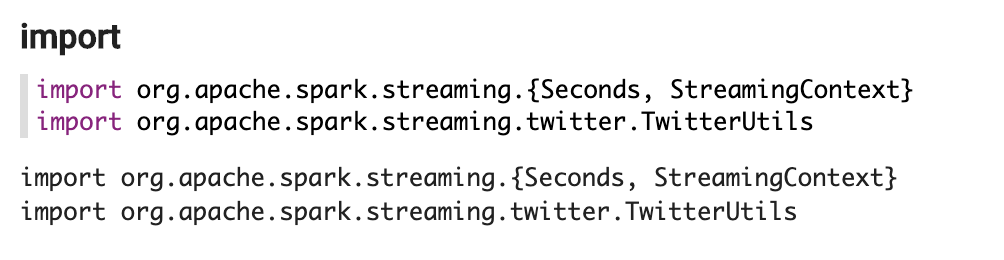

In [7]:
Image('./capture/twitter_00.png')

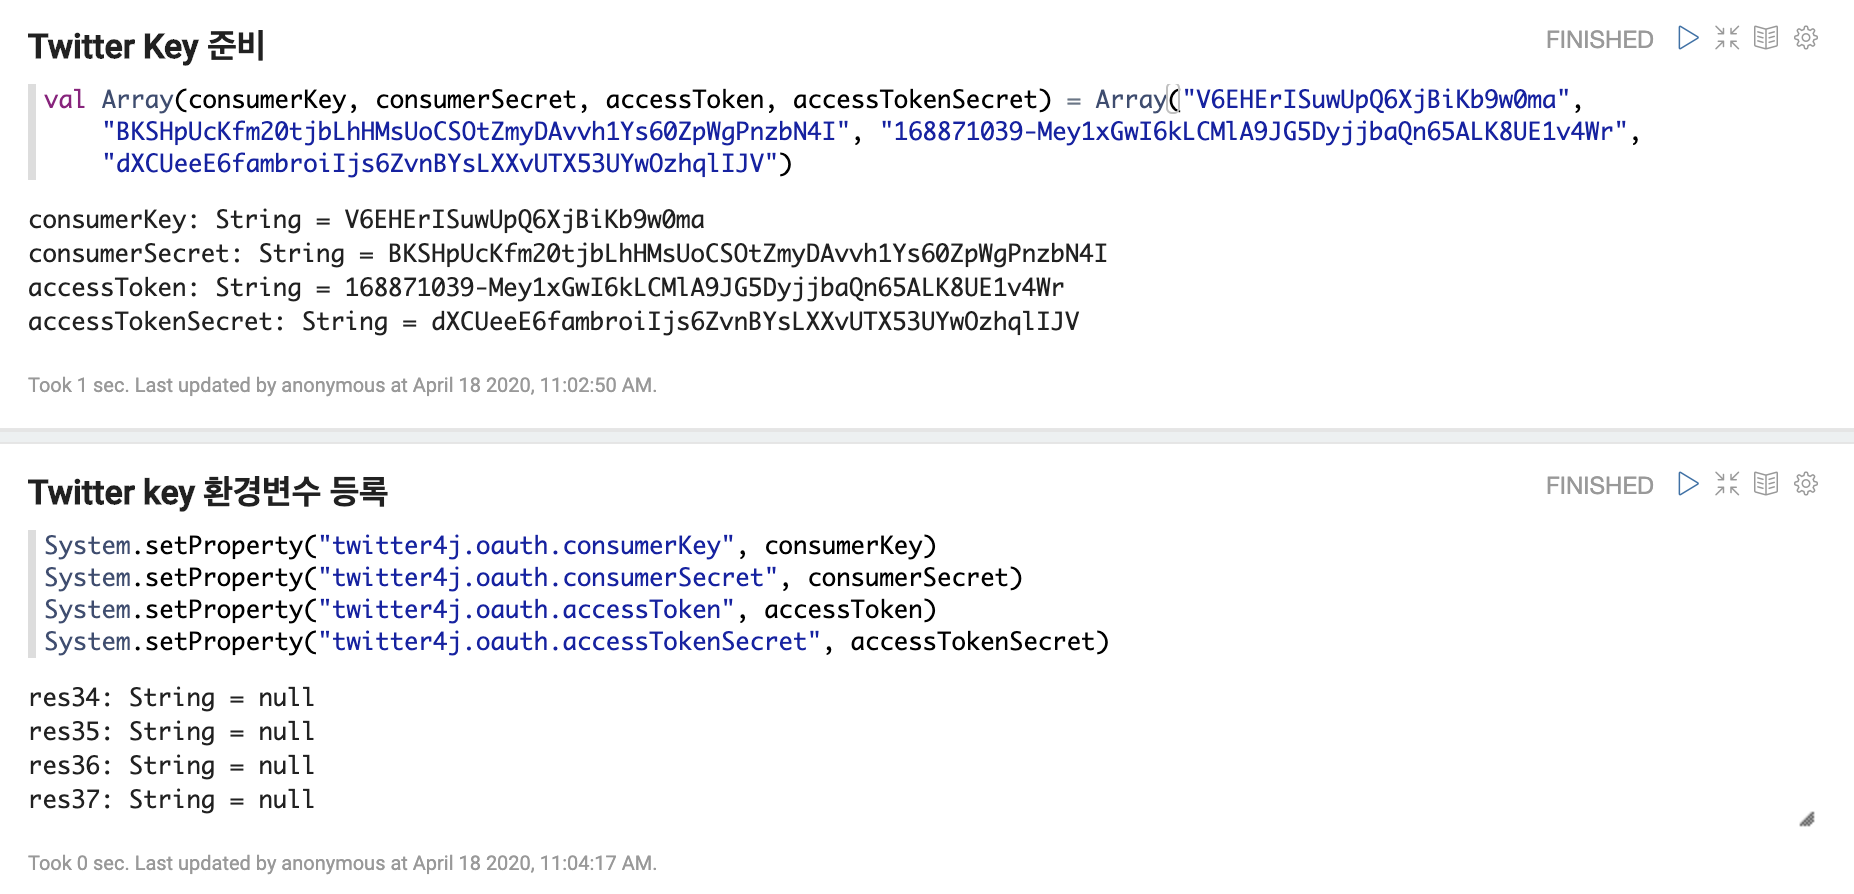

In [4]:
Image('./capture/twitter_01.png')

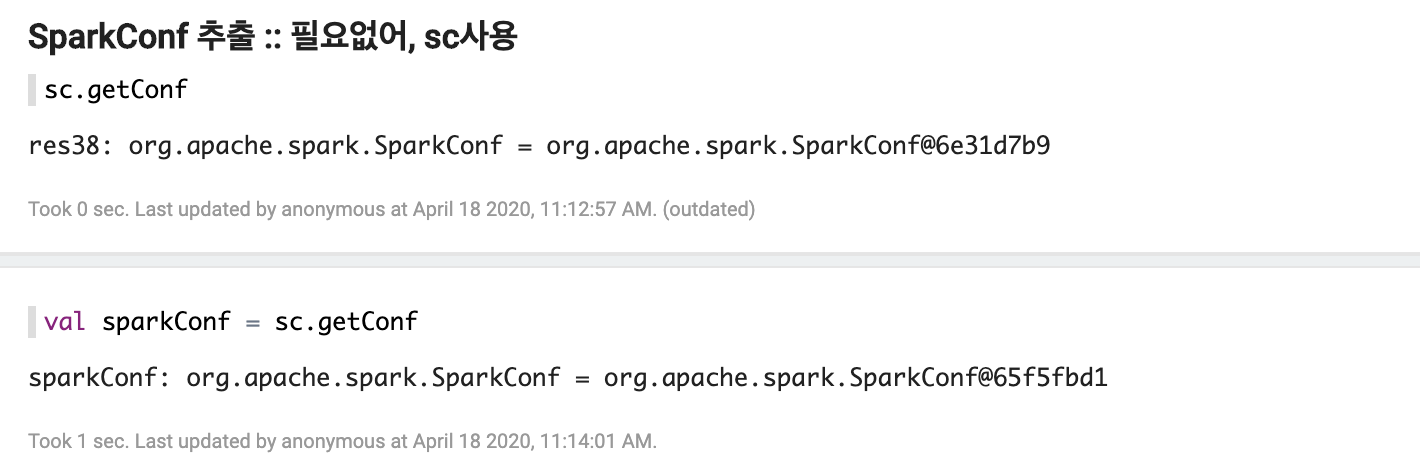

In [5]:
Image('./capture/twitter_01_1.png')

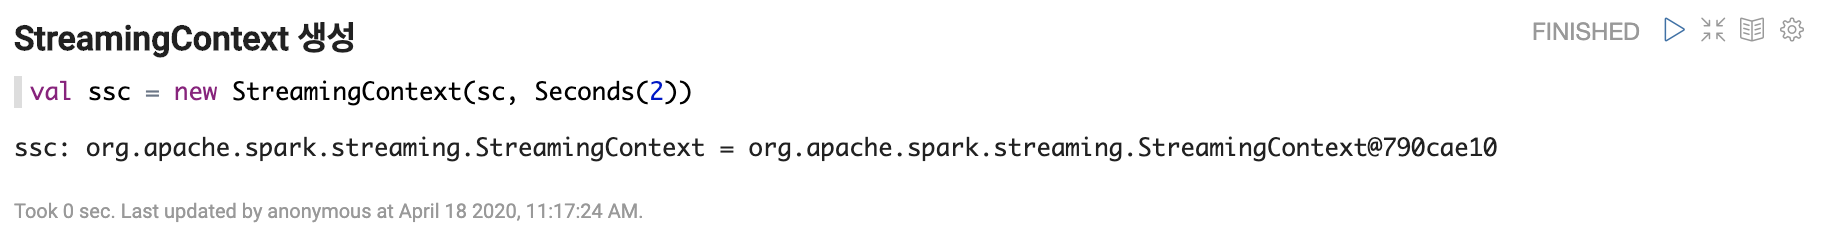

In [3]:
Image('./capture/twitter_02.png')

 - SparkConf 는 사용하지 않음 : sc로 대체
 
 ----
#### Twitter Stream 생성

    val stream = TwitterUtils.createStream(ssc, None)
     : TwitterUtils로 Twitter API를 update
    
    
------ 

    val stream = TwitterUtils.createStream(ssc, Utils.getAuth)
    : change

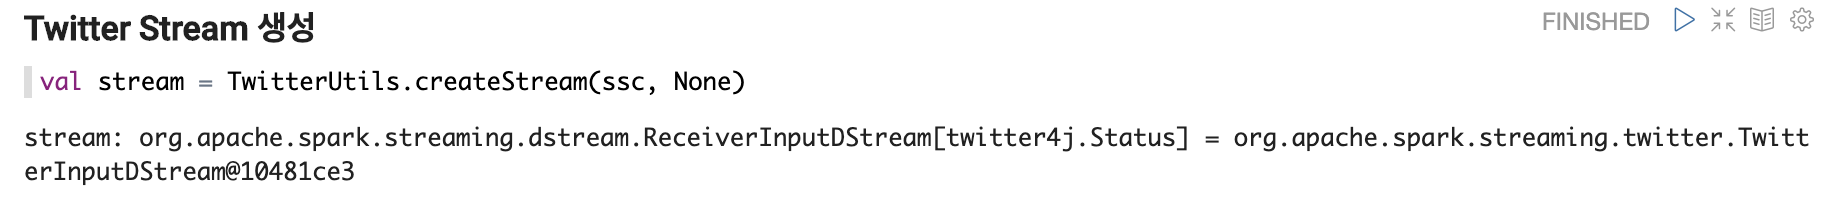

In [8]:
Image('./capture/twitter_04.png')

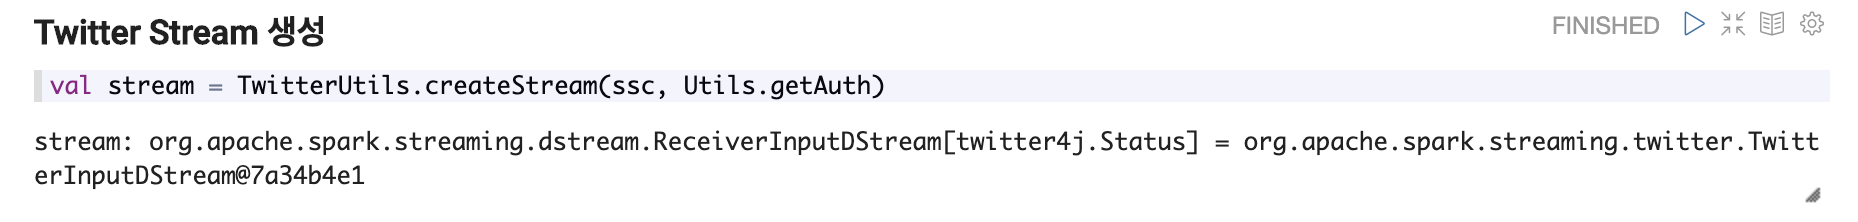

In [14]:
Image('./capture/twitter_change.png')

-----
#### Apache Bahir

 - Spark / Flink : 경쟁관계
 - http://bahir.apache.org/docs/spark/2.3.2/spark-streaming-twitter/
 - spark.jars.package (주소지정) / spark.jars (파일지정)

$ bin/spark-shell --packages org.apache.bahir:spark-streaming-twitter_2.11:2.3.2

    <groupId>org.apache.bahir</groupId>
    <artifactId>spark-streaming-twitter_2.11</artifactId>
    <version>2.3.2</version> : scala version


----- 

#### spark2 interpreter add

spark.jars.packages //  org.apache.bahir:spark-streaming-twitter_2.11:2.3.2

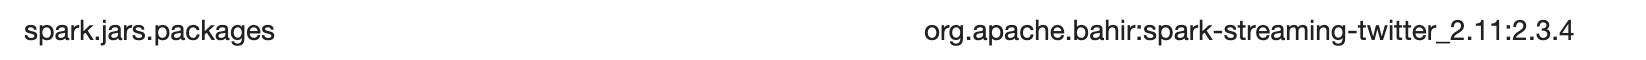

In [6]:
Image('./capture/twitter_03.png')

-----
#### hashtag 발라내기

    val hashTags = stream.flatMap(status => 
        status.getText.split(" ").filter(_.startsWith("#")))

---------
 - status.getHashtagEntities 로 대체 가능
 - flatMap : 계층단위로 되어 있는 것을 flat하게 
 - status : text, Id, locate, time, Retweet ... 
 
-------
#### 60s RDD hashtag count

    val topCounts60 = hashTags.map((_, 1)).reduceByKeyAndWindow(_ + _, Seconds(60))
     .map{case (topic, count) => (count, topic)}
     .transform(_.sortByKey(false))
     
------
     
 - reduceByKeyAndWindow(_ + _, Seconds(60)) \
     $\rightarrow$ streaming window : 현재로부터 과거 60초
     
----
#### 10s RDD hashtag count

    val topCounts10 = hashTags.map((_, 1)).reduceByKeyAndWindow(_ + _, Seconds(10))
     .map{tuple => (tuple._2, tuple._1)}
     .transform(_.sortBy(_._1, false))


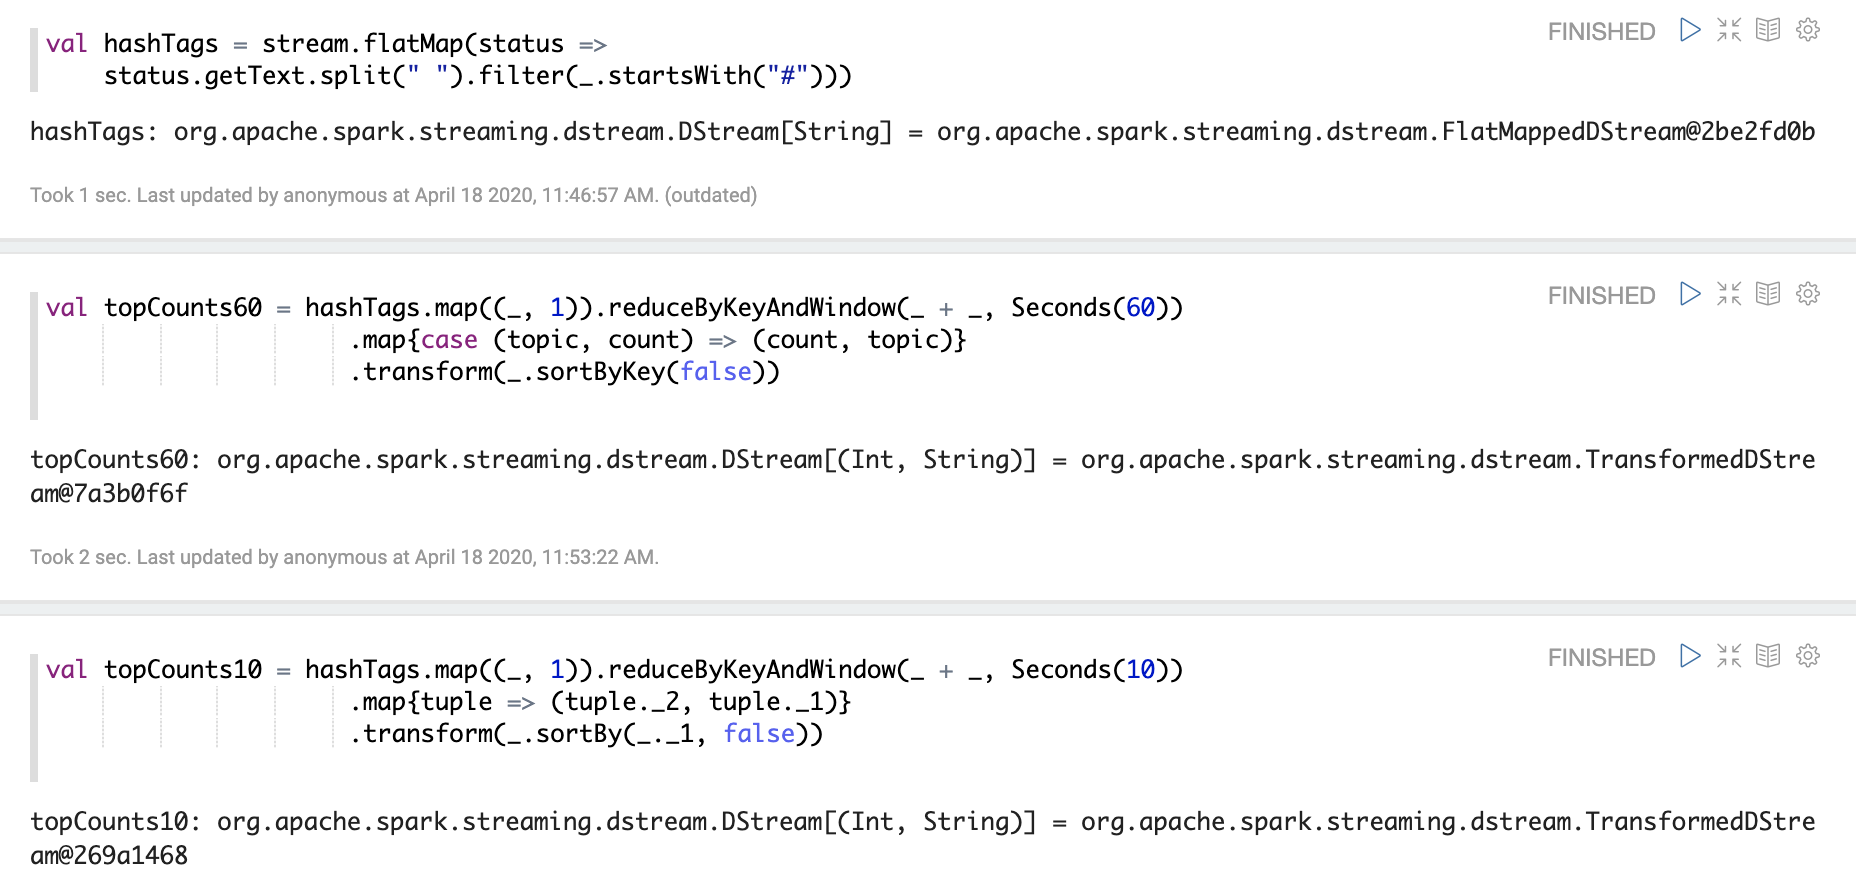

In [9]:
Image('./capture/twitter_05.png')

----
#### 60s RDD > DF >  TempView
    topCounts60.foreachRDD(rdd => {
        rdd.toDF("count", "hashtag").createOrReplaceTempView("topCounts60")})
        
----
#### 10s RDD > DF > TempView
    topCounts10.foreachRDD(rdd => {
        rdd.toDF("count", "hashtag").createOrReplaceTempView("topCounts10")
        })  
        
-----
#### Streaming start
    ssc.start()

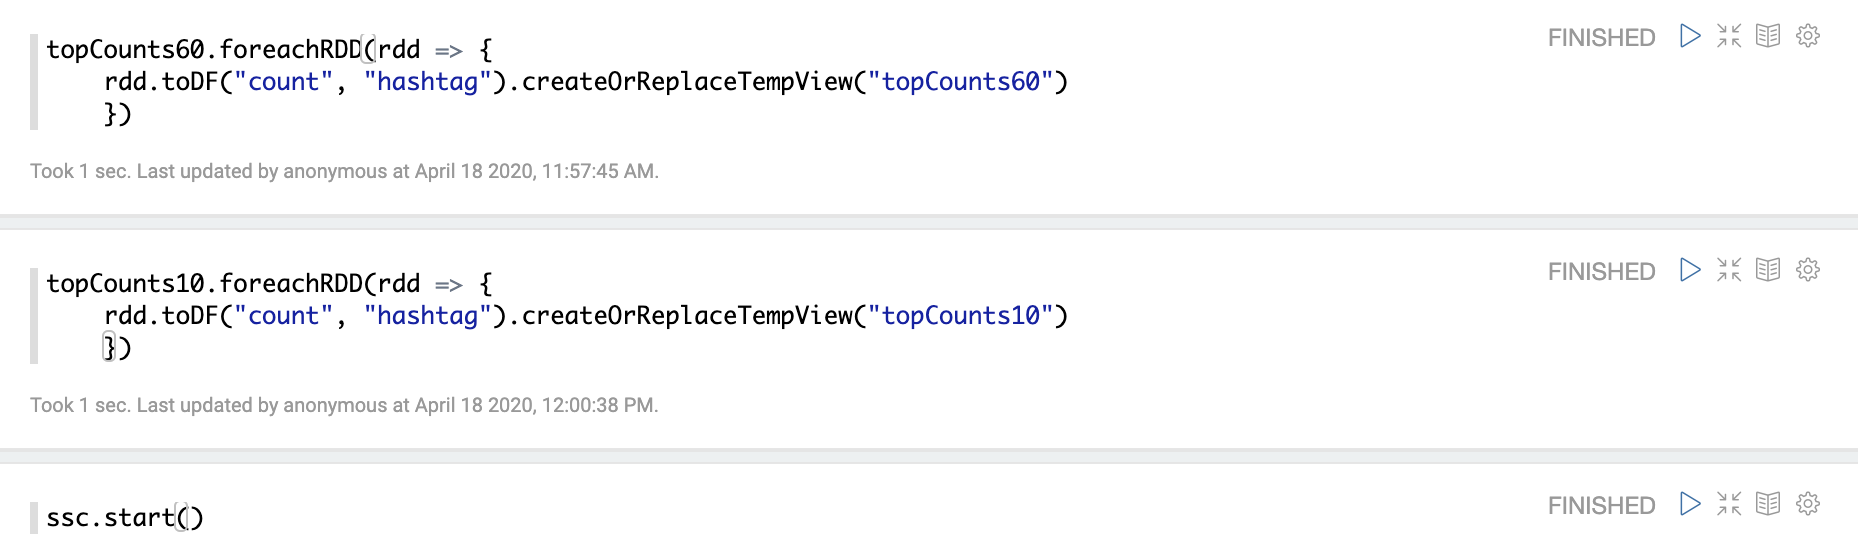

In [10]:
Image('./capture/twitter_06.png')

------

    %sql
    select * from topCounts60